In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Utils import basicu

# L2 cell type centroids

In [2]:
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad'
adata = anndata.read(f)
adata

AnnData object with n_obs × n_vars = 73347 × 45768
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'ce

In [3]:
labels = adata.obs['neighborhood_label'].values
genes = adata.var.index.values
covall = np.asarray(adata.X.sum(axis=1)).reshape(-1,)
covtypes, types = basicu.group_sum(covall.reshape(-1,1), labels)
covtypes.shape, types.shape

((8, 1), (8,))

In [4]:
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_seq/degenes_yao_2021_cell.csv'
gs = pd.read_csv(f, header=None)[0].values
print(gs.shape)
genes = np.intersect1d(genes, gs)
print(genes.shape)
genes

(5981,)
(5967,)


array(['0610040J01Rik', '1110008P14Rik', '1110012L19Rik', ..., 'Zwint',
       'Zyg11a', 'Zyx'], dtype=object)

In [5]:
adata2 = adata[:,genes]
adata2

View of AnnData object with n_obs × n_vars = 73347 × 5967
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_labe

In [6]:
def get_ftrs(mat, labels, cov=None):
    """
    """
    ctrds, types = basicu.group_sum(mat, labels)
    if cov is None:
        cov = np.sum(ctrds, axis=1)
    cpms = ctrds/cov.reshape(-1,1)*1e6
    ftrs = np.log10(cpms+1)
    return ftrs, types

In [7]:
mat = np.asarray(adata2.X.todense())
ftrs, types = get_ftrs(mat, labels)
types

array(['CGE', 'DG/SUB/CA', 'L2/3 IT', 'L4/5/6 IT Car3', 'MGE',
       'NP/CT/L6b', 'Other', 'PT'], dtype=object)

In [8]:
ftrs.shape

(8, 5967)

In [9]:
sel_types = ['NP/CT/L6b', 'DG/SUB/CA', 'MGE']
sel_type_idxs = basicu.get_index_from_array(types, sel_types)
sel_type_idxs

array([5, 1, 4])

(67,)
/bigstore/GeneralStorage/fangming/projects/dredfish/res_seq/validation_genes_NP_CT_L6b.txt
(113,)
/bigstore/GeneralStorage/fangming/projects/dredfish/res_seq/validation_genes_DG_SUB_CA.txt
(107,)
/bigstore/GeneralStorage/fangming/projects/dredfish/res_seq/validation_genes_MGE.txt


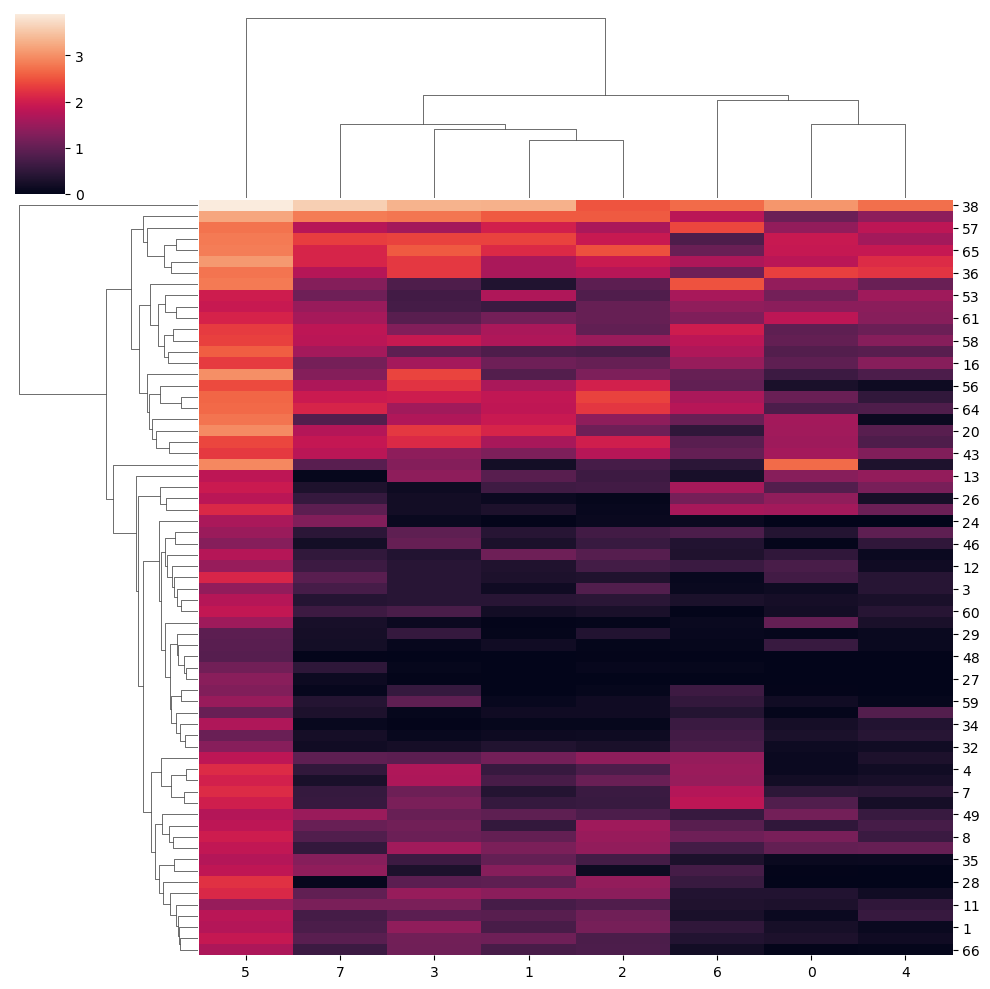

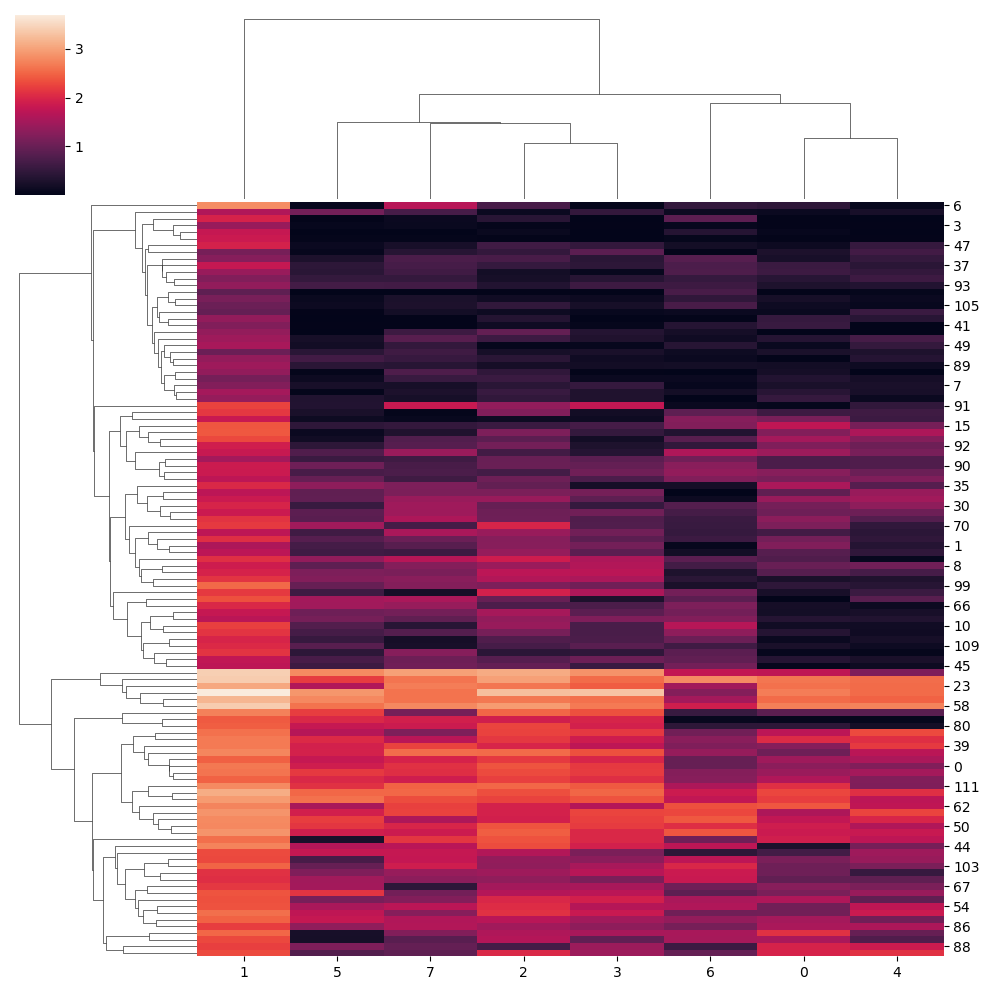

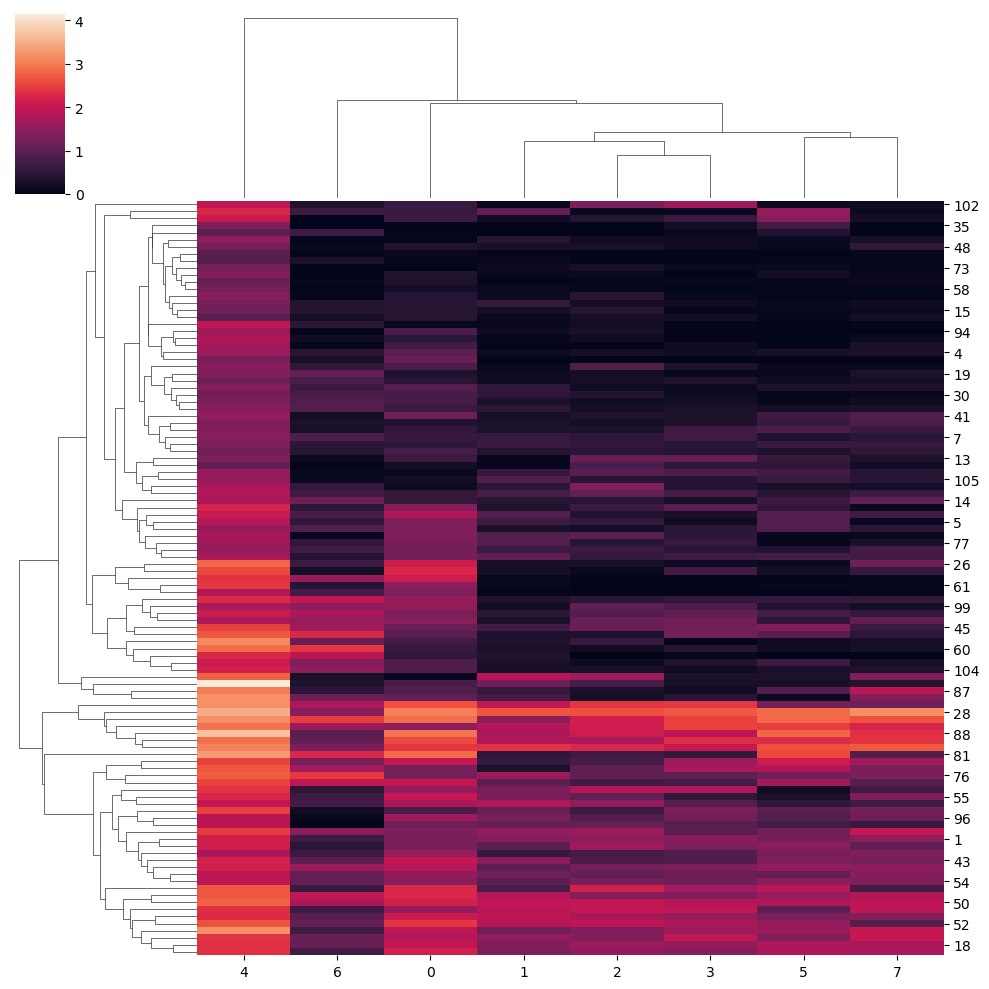

In [10]:
for type_idx, type_tag in zip(sel_type_idxs, sel_types):
    type_tag = type_tag.replace(' ', "_").replace('/', '_')
    # type_idx = 2
    # type_tag = "L2/3 IT"
    
    fg, bg = ftrs[[type_idx]], ftrs[[i for i in range(len(types)) if i != type_idx]]
    
    mfg = np.mean(fg, axis=0)
    mbg = np.mean(bg, axis=0)
    diff = mfg - mbg
    diffmin = np.min(fg, axis=0) - np.max(bg, axis=0)

    gsel = genes[np.logical_and(diff>np.log10(5), diffmin>np.log10(1.5))] 
    gselidx = basicu.get_index_from_array(genes, gsel)
    ftrs_sel = ftrs[:,gselidx]
    print(gsel.shape)
    
    sns.clustermap(ftrs_sel.T, xticklabels=True)

    fout = f"/bigstore/GeneralStorage/fangming/projects/dredfish/res_seq/validation_genes_{type_tag}.txt"
    print(fout)
    np.savetxt(fout, gsel, fmt='%s')